<a href="https://colab.research.google.com/github/Hrenani/Image_Captioning/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torchmetrics

In [ ]:
!pip install -q portalocker>=2.0.0

In [ ]:
!pip uninstall -y torch torchtext torchvision torchdata numpy tqdm
!pip install numpy==1.22.0 torch==1.12.0 torchtext==0.13.0 torchvision==0.13.0 tqdm==4.64.0

Found existing installation: torch 2.5.0+cu121
Uninstalling torch-2.5.0+cu121:
  Successfully uninstalled torch-2.5.0+cu121
Found existing installation: torchvision 0.20.0+cu121
Uninstalling torchvision-0.20.0+cu121:
  Successfully uninstalled torchvision-0.20.0+cu121
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: tqdm 4.66.5
Uninstalling tqdm-4.66.5:
  Successfully uninstalled tqdm-4.66.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not 

In [ ]:
!pip uninstall torchaudio -y
!pip install torcheval

Found existing installation: torchaudio 2.5.0+cu121
Uninstalling torchaudio-2.5.0+cu121:
  Successfully uninstalled torchaudio-2.5.0+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.7 MB/s eta 0:00:00


In [ ]:
import os
from collections import defaultdict
from typing import Any, Callable, Dict, List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torchvision
from torchvision import transforms
from torchvision.datasets import VisionDataset
from torchvision.models import resnet50, ResNet50_Weights

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence

from torch import optim
from torch.nn import functional as F

from torcheval.metrics import BLEUScore

import tqdm
import torchmetrics as tm

/usr/local/lib/python3.10/dist-packages/torchmetrics/__init__.py:24: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.0)
  import scipy.signal


In [ ]:
for lib in [np, torch, torchtext, torchvision, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.22.0
torch --> 1.12.0+cu102
torchtext --> 0.13.0
torchvision --> 0.13.0+cu102
tqdm --> 4.64.0


In [ ]:
class AverageMeter(object):
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n = 1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [ ]:
seed = 42

batch_size = 128

embed_size = 300
hidden_size = 500
num_layers = 2
dropout_embd = 0.5
dropout_rnn = 0.5
max_seq_length = 20

clip = 0.25

lr = 0.1
momentum = 0.9
wd = 1e-4


##Download the Flickr8k Dataset

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!mkdir /content/data

!unzip -qq Flickr8k_Dataset.zip -d /content/data
!unzip -qq Flickr8k_text.zip -d /content/data

!rm Flickr8k_Dataset.zip Flickr8k_text.zip

##  Custom dataset

In [ ]:
class Flickr8k(VisionDataset):
    """
    Args:
        root (string): Root directory where images are downloaded to.
        ann_file (string): Path to annotation file.
        transform (callable, optional): A function/transform that takes in a PIL image
            and returns a transformed version. E.g, ``transforms.PILToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    def __init__(
        self,
        root: str,
        ann_file: str,
        split_file: str,
        train: bool,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.ann_file = os.path.expanduser(ann_file)
        self.train = train

        # Read {train/dev/test} files
        with open(split_file) as f:
            self.split_samples = f.read().strip().split("\n")

        # Read annotations and store in a dict
        self.ids, self.captions = [], []
        with open(self.ann_file) as fh:
            for line in fh:
                img_id, caption = line.strip().split("\t")
                if img_id[:-2] in self.split_samples:
                    self.ids.append(img_id[:-2])
                    self.captions.append(caption)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is a list of captions for the image.
        """
        img_id = self.ids[index]

        # Image
        filename = os.path.join(self.root, img_id)
        img_raw = Image.open(filename).convert("RGB")
        if self.transform is not None:
            img = self.transform(img_raw)

        # Captions
        caption = self.captions[index]
        if self.target_transform is not None:
            target = self.target_transform(caption)

        if self.train:
            return img, target
        else:
          return img, img_raw, caption

    def __len__(self) -> int:
        return len(self.ids)

In [ ]:
class CaptionTransform:
  def __init__(self, caption_file):
    captions = self._load_captions(caption_file)

    self.tokenizer = get_tokenizer('basic_english')
    self.vocab = build_vocab_from_iterator(map(self.tokenizer, captions),
                                           specials = ['<pad>', '<unk>', '<sos>', '<eos>'])

    self.vocab.set_default_index(self.vocab['<unk>'])

    torch.save(self.vocab, 'vocab.pt')

  def __call__(self, caption):
    indices = self.vocab(self.tokenizer(caption))
    indices = self.vocab(['<sos>']) + indices + self.vocab(['<eos>'])
    target = torch.LongTensor(indices)
    return target

  def __repr__(self):
    return f"""CaptionTransform([
      _load_caption(),
      tokenizer('basic_english'),
      vocab(vocab_size = {len(self.vocab)})
    ])"""

  def _load_captions(self, caption_file):
    captions = []
    with open(caption_file) as f:
      for line in f:
        _, caption = line.strip().split('\t')
        captions.append(caption)
    return captions


In [ ]:
caption_transform = CaptionTransform('/content/data/Flickr8k.token.txt')
print(caption_transform)
print(len(caption_transform.vocab))
caption_transform('how are you')

CaptionTransform([
      _load_caption(),
      tokenizer('basic_english'),
      vocab(vocab_size = 8915)
    ])
8915


tensor([   2, 1352,   19, 1382,    3])

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
dataset = Flickr8k('/content/data/Flicker8k_Dataset',
                   '/content/data/Flickr8k.token.txt',
                   '/content/data/Flickr_8k.trainImages.txt',
                   train = True,
                   transform = transform,
                   target_transform = caption_transform)
dataset

Dataset Flickr8k
    Number of datapoints: 30000
    Root location: /content/data/Flicker8k_Dataset
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Target transform: CaptionTransform([
                        _load_caption(),
                        tokenizer('basic_english'),
                        vocab(vocab_size = 8915)
                      ])

In [ ]:
img, caption = dataset[50]
print(caption)
img

tensor([ 2,  4, 30, 10, 16, 11,  9, 35, 36,  7, 47,  5,  3])


tensor([[[0.0941, 0.1059, 0.1255,  ..., 0.2392, 0.2275, 0.2235],
         [0.1098, 0.1176, 0.1137,  ..., 0.2471, 0.2431, 0.2431],
         [0.1020, 0.1255, 0.1255,  ..., 0.2745, 0.2667, 0.2667],
         ...,
         [0.8706, 0.8706, 0.8667,  ..., 0.8824, 0.8745, 0.8784],
         [0.8627, 0.8627, 0.8627,  ..., 0.8784, 0.8667, 0.8627],
         [0.8667, 0.8667, 0.8667,  ..., 0.8706, 0.8510, 0.8471]],

        [[0.1098, 0.1098, 0.1294,  ..., 0.1686, 0.1569, 0.1529],
         [0.1176, 0.1255, 0.1137,  ..., 0.1725, 0.1686, 0.1686],
         [0.1020, 0.1255, 0.1255,  ..., 0.1882, 0.1804, 0.1804],
         ...,
         [0.8784, 0.8784, 0.8745,  ..., 0.8784, 0.8745, 0.8784],
         [0.8706, 0.8706, 0.8706,  ..., 0.8745, 0.8667, 0.8627],
         [0.8667, 0.8667, 0.8667,  ..., 0.8667, 0.8510, 0.8471]],

        [[0.0549, 0.0784, 0.1059,  ..., 0.1216, 0.1098, 0.0980],
         [0.0667, 0.0824, 0.0824,  ..., 0.1176, 0.1137, 0.1137],
         [0.0627, 0.0784, 0.0784,  ..., 0.1333, 0.1255, 0.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

root = '/content/data/Flicker8k_Dataset'
ann_file = '/content/data/Flickr8k.token.txt'
split_file = lambda phase: f'/content/data/Flickr_8k.{phase}Images.txt'

caption_transform = CaptionTransform(ann_file)

train_set = Flickr8k(root, ann_file, split_file('train'), True, train_transform, caption_transform)
valid_set = Flickr8k(root, ann_file, split_file('dev'), True, eval_transform, caption_transform)
test_set = Flickr8k(root, ann_file, split_file('test'), False, eval_transform, caption_transform)

len(train_set), len(valid_set), len(test_set)

(30000, 5000, 5000)

##  Define a dataloader

In [ ]:
def collate_fn(batch):
  if len(batch[0]) == 2:
      x_batch, y_batch = zip(*batch)
      x_batch = torch.stack(x_batch)
      y_batch = pad_sequence(y_batch, batch_first=True, padding_value=caption_transform.vocab['<pad>'])
      return x_batch, y_batch
  else:
    x_batch, x_raw, captions = zip(*batch)
    x_batch = torch.stack(x_batch)
    return x_batch, x_raw, captions

In [ ]:
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True, collate_fn = collate_fn)
valid_loader = DataLoader(valid_set, batch_size = batch_size*2, collate_fn = collate_fn)
test_loader = DataLoader(test_set, batch_size = batch_size*2, collate_fn = collate_fn)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128, 27]))

#  **Model**

In [ ]:
class EncoderCNN(nn.Module):
  def __init__(self, embed_size):
    super(EncoderCNN, self).__init__()

    # Load a pre-trained ResNet model
    self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    self.resnet.requires_grad_(False)
    feature_size = self.resnet.fc.in_features

    # Remove the classification layer
    self.resnet.fc = nn.Identity()

    # Add linear layer to transform extracted features to the embedding size
    self.linear = nn.Linear(feature_size, embed_size)
    self.bn = nn.BatchNorm1d(embed_size)

  def forward(self, images):
    self.resnet.eval()
    with torch.no_grad():
      features = self.resnet(images)
    features = self.bn(self.linear(features))
    return features

In [ ]:
encoder_temp = EncoderCNN(embed_size = 300)
encoder_temp(x_batch).shape

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

torch.Size([128, 300])

In [ ]:
num_trainable_params(encoder_temp)

0.6153

In [ ]:
class DecoderRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout_embd, dropout_rnn, max_seq_length=20):
    super(DecoderRNN, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=caption_transform.vocab['<pad>'])
    self.dropout_embd = nn.Dropout(dropout_embd)

    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout_rnn, batch_first=True)

    self.linear = nn.Linear(hidden_size, vocab_size)
    self.max_seq_length = max_seq_length

    self.init_weights()

  def init_weights(self):
      self.embedding.weight.data.uniform_(-0.1, 0.1)
      self.linear.bias.data.fill_(0)
      self.linear.weight.data.uniform_(-0.1, 0.1)

  def forward(self, features, captions):
    embeddings = self.dropout_embd(self.embedding(captions[:, :-1]))
    inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
    outputs, _ = self.lstm(inputs)
    outputs = self.linear(outputs)
    return outputs

  def generate(self, features, captions):
    if len(captions) > 0:
        embeddings = self.dropout_embd(self.embedding(captions))
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
    else:
        inputs = features.unsqueeze(1)

    outputs, _ = self.lstm(inputs)
    outputs = self.linear(outputs)
    return outputs

In [ ]:
decoder_temp = DecoderRNN(embed_size=300, hidden_size=500,
                          vocab_size=len(caption_transform.vocab),
                          num_layers=2,
                          dropout_embd=0.5,
                          dropout_rnn=0.5)
decoder_temp

DecoderRNN(
  (embedding): Embedding(8915, 300, padding_idx=0)
  (dropout_embd): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 500, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=500, out_features=8915, bias=True)
)

In [ ]:
feature_temp = encoder_temp(x_batch)

In [ ]:
decoder_temp(feature_temp, y_batch).shape

torch.Size([128, 27, 8915])

In [ ]:
num_trainable_params(decoder_temp)

10.748915

In [ ]:
class ImageCaptioning(nn.Module):

  def __init__(self, embed_size, hidden_size, vocab_size, num_layers,
               dropout_embd, dropout_rnn, max_seq_length=20):
    super(ImageCaptioning, self).__init__()
    self.encoder = EncoderCNN(embed_size)
    self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers,
                              dropout_embd, dropout_rnn, max_seq_length)

  def forward(self, images, captions):
    features = self.encoder(images)
    outputs = self.decoder(features, captions)
    return outputs

  def generate(self, images, captions):
    features = self.encoder(images)
    outputs = self.decoder.generate(features, captions)
    return outputs

In [ ]:
model = ImageCaptioning(300, 500, len(caption_transform.vocab),
                        2, 0.5, 0.5)
model

ImageCaptioning(
  (encoder): EncoderCNN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [ ]:
model(x_batch, y_batch).shape

torch.Size([128, 27, 8915])

In [ ]:
num_trainable_params(model)

11.364215

#  **Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index = caption_transform.vocab['<pad>'])
metic = None

#  **Train**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  if metric: metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))

      if metric:
        metric.update(outputs, targets)
        metric_train_val = metric.compute().item()
      else:
        metric_train_val = None

      tepoch.set_postfix(loss=loss_train.avg, metric=metric_train_val)

    return model, loss_train.avg, metric_train_val

#  **Evaluation**

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  if metric: metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n = len(targets))

      if metric: metric(outputs, targets)

  return loss_eval.avg, metric.compute().item() if metric else None

#  **Training Process**

In [ ]:
model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                        dropout_embd, dropout_rnn, max_seq_length).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs, targets)
  loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

print(loss)

tensor(9.0936, device='cuda:0')


In [ ]:
model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                        dropout_embd, dropout_rnn, max_seq_length).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum)

In [ ]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set) - mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20, collate_fn = collate_fn)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, None, epoch)

Epoch 99: 100%|██████████| 50/50 [00:10<00:00,  4.66batch/s, loss=0.0322, metric=None]


In [ ]:
torch.cuda.empty_cache()

In [ ]:
num_epochs = 1
for lr in [2, 1, 0.9, 0.5, 0.1, 0.05, 0.005]:
  print(f"LR= {lr}")

  model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                          dropout_embd, dropout_rnn, max_seq_length).to(device)
  optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=wd, momentum = momentum)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, None, epoch+1)

  print()

LR= 2


Epoch 1: 100%|██████████| 235/235 [04:56<00:00,  1.26s/batch, loss=4.55, metric=None]



LR= 1


Epoch 1: 100%|██████████| 235/235 [04:48<00:00,  1.23s/batch, loss=4.37, metric=None]



LR= 0.9


Epoch 1: 100%|██████████| 235/235 [04:52<00:00,  1.24s/batch, loss=4.37, metric=None]



LR= 0.5


Epoch 1: 100%|██████████| 235/235 [04:48<00:00,  1.23s/batch, loss=4.65, metric=None]



LR= 0.1


Epoch 1:  10%|▉         | 23/235 [00:29<04:31,  1.28s/batch, loss=8.57, metric=None]


KeyboardInterrupt: 

In [ ]:
num_epochs = 1
for lr in [1.5, 1.25]:
  print(f"LR= {lr}")

  model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                          dropout_embd, dropout_rnn, max_seq_length).to(device)
  optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay=wd, momentum = momentum)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, None, epoch+1)

  print()

LR= 1.5


Epoch 1: 100%|██████████| 235/235 [04:50<00:00,  1.23s/batch, loss=5.06, metric=None]



LR= 1.25


Epoch 1: 100%|██████████| 235/235 [04:51<00:00,  1.24s/batch, loss=4.41, metric=None]

In [ ]:
lr = 1
for wd in [1e-4, 1e-5, 1e-6, 0]:
  print(f"LR = {lr}, WD = {wd}")

  model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                          dropout_embd, dropout_rnn, max_seq_length).to(device)

  optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = wd, momentum = momentum)


  for epoch in range(num_epochs):
    model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, None, epoch+1)

  print()

LR = 1, WD = 0.0001


Epoch 1: 100%|██████████| 235/235 [04:48<00:00,  1.23s/batch, loss=4.39, metric=None]



LR = 1, WD = 1e-05


Epoch 1: 100%|██████████| 235/235 [04:49<00:00,  1.23s/batch, loss=4.34, metric=None]



LR = 1, WD = 1e-06


Epoch 1: 100%|██████████| 235/235 [04:48<00:00,  1.23s/batch, loss=4.3, metric=None]



LR = 1, WD = 0


Epoch 1: 100%|██████████| 235/235 [04:47<00:00,  1.22s/batch, loss=4.38, metric=None]

##  Main Loop

In [ ]:
torch.cuda.empty_cache()

In [ ]:
set_seed(seed)
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, collate_fn= collate_fn)

In [ ]:
from time import time
import multiprocessing as mp

for num_workers in range(0, mp.cpu_count()+1, 2):
  train_loader = DataLoader(train_set, batch_size = 128, shuffle = True, collate_fn=collate_fn,
                            num_workers = num_workers, pin_memory=True)
  print('-' * 10)
  start = time()
  for i, data in enumerate(train_loader, num_workers):
    pass
  end = time()
  print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

----------
Finish with:180.5350456237793 second, num_workers=0
----------
Finish with:167.9357566833496 second, num_workers=2


In [ ]:
mp.cpu_count()

2

In [ ]:
set_seed(seed)
model = ImageCaptioning(embed_size, hidden_size, len(caption_transform.vocab), num_layers,
                        dropout_embd, dropout_rnn, max_seq_length).to(device)

In [ ]:
set_seed(seed)
lr = 1
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = wd, momentum = momentum)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
  #Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    None,
                                                    epoch+1)

  #validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      None)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)


  if loss_valid < best_loss_valid:
    torch.save(model, f'image_captioning_model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: loss = {loss_valid:.4}, Metric = None')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 235/235 [03:40<00:00,  1.07batch/s, loss=2.07, metric=None]


Valid: loss = 2.749, Metric = None



Epoch 2: 100%|██████████| 235/235 [03:26<00:00,  1.14batch/s, loss=2.01, metric=None]


Valid: loss = 2.764, Metric = None



Epoch 3: 100%|██████████| 235/235 [03:27<00:00,  1.13batch/s, loss=1.95, metric=None]


Valid: loss = 2.778, Metric = None



Epoch 4: 100%|██████████| 235/235 [03:29<00:00,  1.12batch/s, loss=1.89, metric=None]


Valid: loss = 2.787, Metric = None



Epoch 5: 100%|██████████| 235/235 [03:28<00:00,  1.12batch/s, loss=1.84, metric=None]


Valid: loss = 2.816, Metric = None



In [ ]:
epoch_counter = 15

##  Plot

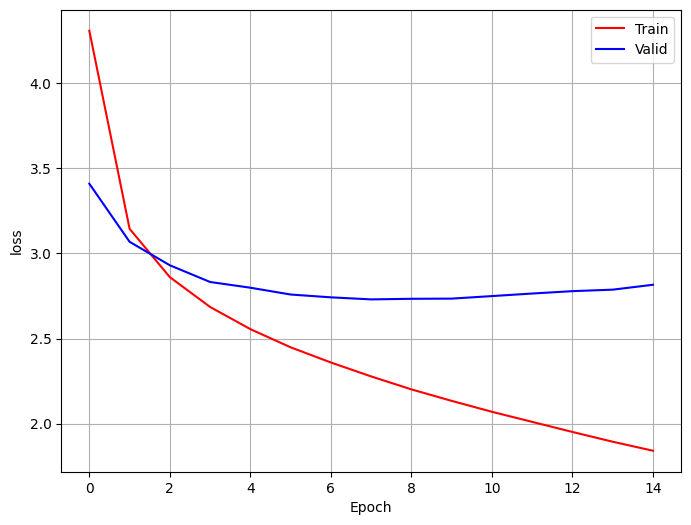

In [ ]:
plt.figure(figsize = (8,6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label = "Train")
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label = "Valid")

plt.xlabel("Epoch")
plt.ylabel("loss")
plt.grid(True)
plt.legend()

#  **Caption**

In [ ]:
model_path = 'image_captioning_model.pt'
model = torch.load(model_path)
model.eval()
print()

In [ ]:
def generate(image, model, vocab, max_seq_len, device):
  image = image.to(device)
  src, indices = [], []

  caption = ''
  itos = vocab.get_itos()

  for i in range(max_seq_length):
    with torch.no_grad():
      predictions = model.generate(image, src)

    idx = predictions[:, -1, :].argmax(1)
    token = itos[idx]

    caption += token + ' '
    if idx == vocab['<eos>']:
      break

    indices.append(idx)
    src = torch.LongTensor([indices]).to(device)

  return caption.replace('<sos>', '').replace('<eos>', '').capitalize()

In [ ]:
test_set_generate = Flickr8k(root, ann_file, split_file('test'), False, eval_transform, caption_transform)

target:  A little tan dog with large ears running through the grass .
model:   a dog running through a grassy field .  


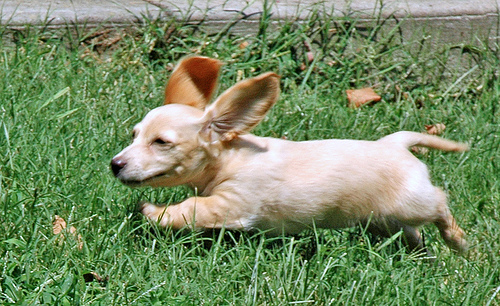

In [ ]:
idx = torch.randint(0, len(test_set_generate), (1,)).item()
image, image_raw, target = test_set_generate[30]

caption = generate(image.unsqueeze(0), model, caption_transform.vocab, 20, device)

print("target: ", target)
print("model: " , caption)
image_raw

#  **Test**

In [ ]:
def calculate_bleu(model, dataloader, tokenizer, vocab, n_gram, device, max_seq_len=20):
  bleu = BLEUScore(n_gram=n_gram)
  for images, _, captions in dataloader:
      images = images.to(device)

      # Generate caption using the model
      generated_caption = generate(images[[0], ...], model, vocab, max_seq_len, device)

      candidates = [generated_caption]
      references = [captions]

      bleu.update(candidates, references)

  return bleu.compute()

In [ ]:
test_set_generate = Flickr8k(root, ann_file, split_file('test'), False, eval_transform, caption_transform)
test_loader = DataLoader(test_set_generate, batch_size= 5, collate_fn = collate_fn)

In [ ]:
_, _, captions = next(iter(test_loader))
captions

('A blond woman in a blue shirt appears to wait for a ride .',
 'A blond woman is on the street hailing a taxi .',
 'A woman is signaling is to traffic , as seen from behind .',
 'A woman with blonde hair wearing a blue tube top is waving on the side of the street .',
 'The woman in the blue dress is holding out her arm at oncoming traffic .')

In [ ]:
bleu_1 = calculate_bleu(model, test_loader, caption_transform.tokenizer, caption_transform.vocab, 1, device)
bleu_2 = calculate_bleu(model, test_loader, caption_transform.tokenizer, caption_transform.vocab, 2, device)
bleu_3 = calculate_bleu(model, test_loader, caption_transform.tokenizer, caption_transform.vocab, 3, device)
bleu_4 = calculate_bleu(model, test_loader, caption_transform.tokenizer, caption_transform.vocab, 4, device)

In [ ]:
print(f'BLEU 1: {bleu_1}\nBLEU 2: {bleu_2}\nBLEU 3: {bleu_3}\nBLEU 4: {bleu_4}')

BLEU 1: 0.5603844889911271
BLEU 2: 0.34926846434876524
BLEU 3: 0.2209962730037933
BLEU 4: 0.14005855890835292
